In [2]:
import argparse
import faiss
import numpy as np
import pandas as pd
import h5py
import torch
import os
import subprocess
import cirtorch
from src import utils
from sklearn.decomposition import PCA


parser = argparse.ArgumentParser()
parser.add_argument('filename', help='feature files')
parser.add_argument('-d', '--devices', default='0', help='gpu device indexes')
args = parser.parse_args(args=['../experiments/v7/feats_ms_flip_M_ep4_batch_size-32_epochs-5_pooling-G,G,G,G.h5', '-d', '4'])

file_name = args.filename
setting = file_name.split('/')[-1].replace('.h5', '')
os.environ['CUDA_VISIBLE_DEVICES'] = args.devices
topk = 100

with h5py.File(file_name, 'r') as f:
    ids_index = f['ids_index'][()].astype(str)
    feats_index = f['feats_index'][()]
    ids_test = f['ids_test'][()].astype(str)
    feats_test = f['feats_test'][()]

subm = pd.read_csv('../input/retrieval_sample_submission.csv')[['id']]
retrieval_result = pd.DataFrame(ids_test, columns=['id'])

In [3]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import torch
import numpy as np
from sklearn.decomposition import PCA

m = feats_index.mean(axis=0)

centered_feats_index = feats_index - m
centered_feats_test = feats_test - m

cov = centered_feats_index.transpose() @ centered_feats_index
cov /= centered_feats_index.shape[0]

s, u = np.linalg.eig(cov)

order = s.argsort()[::-1]
s = s[order] + 1e-16
u = u[order]

p = np.diag(s ** -0.5) @ u

whitened_feats_index = centered_feats_index @ p.transpose()
whitened_feats_test = centered_feats_test @ p.transpose()

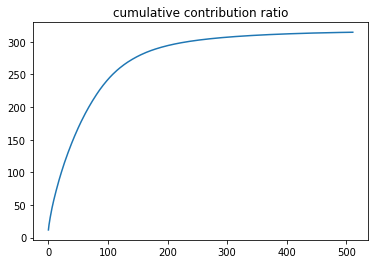

In [6]:
import matplotlib.pyplot as plt
plt.title('cumulative contribution ratio')
plt.plot(s.cumsum());

In [8]:
# pca_dim = 256
# whitened_feats_index = whitened_feats_index[:, :pca_dim]
# whitened_feats_test = whitened_feats_test[:, :pca_dim]

feats_index = utils.l2norm_numpy(whitened_feats_index.astype(np.float32))
feats_test = utils.l2norm_numpy(whitened_feats_test.astype(np.float32))

In [9]:
gpu_index = faiss.IndexFlatL2(feats_index.shape[1])
# gpu_index = faiss.index_cpu_to_all_gpus(cpu_index)
gpu_index.add(feats_index)
dists, topk_idx = gpu_index.search(x=feats_test, k=100)
print('query search done.')

retrieval_result['images'] = np.apply_along_axis(' '.join, axis=1, arr=ids_index[topk_idx])
subm = subm.merge(retrieval_result, on='id', how='left')
subm = subm.fillna(retrieval_result['images'].iloc[0])
output_name = f'../output/wPCA-fulldimension-512_{setting}.csv.gz'
subm.to_csv(output_name, compression='gzip', index=False)
print('saved to ' + output_name)

cmd = f'kaggle c submit -c landmark-retrieval-2019 -f {output_name} -m "" '
print(cmd)
subprocess.run(cmd, shell=True)

query search done.
saved to ../output/wPCA-fulldimension-512_feats_ms_flip_M_ep4_batch_size-32_epochs-5_pooling-G,G,G,G.csv.gz
kaggle c submit -c landmark-retrieval-2019 -f ../output/wPCA-fulldimension-512_feats_ms_flip_M_ep4_batch_size-32_epochs-5_pooling-G,G,G,G.csv.gz -m "" 


CompletedProcess(args='kaggle c submit -c landmark-retrieval-2019 -f ../output/wPCA-fulldimension-512_feats_ms_flip_M_ep4_batch_size-32_epochs-5_pooling-G,G,G,G.csv.gz -m "" ', returncode=0)

In [ ]:
import argparse
import faiss
import numpy as np
import pandas as pd
import h5py
import torch
import os
import subprocess
import cirtorch
from src import utils
from sklearn.decomposition import PCA

file_names = [
    '../experiments/v7/feats_ms_flip_M_ep4_batch_size-32_epochs-5_pooling-G,G,G,G.h5',
    '../experiments/v9/feats_index_0_ms_M_ep4_batch_size-32_model_name-se_resnext101_32x4d_pooling-GeM.h5',
]
weights = [
    1.0,
    0.7,
]
setting = 'fish_se-resnext_concat_baseline'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
topk = 100
qe_topk = 10
n_iter = 2

ids_index = []
feats_index = []
ids_test = []
feats_test = []

for file_name, w in zip(file_names, weights):
    with h5py.File(file_name, 'r') as f:
        ids_index.append(f['ids_index'][()].astype(str))
        feats_index.append(f['feats_index'][()] * w)
        ids_test.append(f['ids_test'][()].astype(str))
        feats_test.append(f['feats_test'][()] * w)

for i in range(len(file_names)):
    order = np.argsort(ids_index[i])
    if i == len(file_names) - 1:
        ids_index = ids_index[i][order]
    feats_index[i] = feats_index[i][order]
    order = np.argsort(ids_test[i])
    if i == len(file_names) - 1:
        ids_test = ids_test[i][order]
    feats_test[i] = feats_test[i][order]
    
feats_index = np.concatenate(feats_index, axis=1)
feats_test = np.concatenate(feats_test, axis=1)

subm = pd.read_csv('../input/retrieval_sample_submission.csv')[['id']]
retrieval_result = pd.DataFrame(ids_test, columns=['id'])

feats_test = utils.l2norm_numpy(feats_test.astype(np.float32))
feats_index = utils.l2norm_numpy(feats_index.astype(np.float32))

In [ ]:
# baseline
print('build index...')
cpu_index = faiss.IndexFlatL2(feats_index.shape[1])
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index)
gpu_index.add(feats_index)
dists, topk_idx = gpu_index.search(x=feats_test, k=topk)
print('query search done.')

retrieval_result['images'] = np.apply_along_axis(' '.join, axis=1, arr=ids_index[topk_idx])
subm = subm.merge(retrieval_result, on='id', how='left')
subm = subm.fillna(retrieval_result['images'].iloc[0])
output_name = f'../output/{setting}.csv.gz'
subm.to_csv(output_name, compression='gzip', index=False)
print('saved to ' + output_name)

cmd = f'kaggle c submit -c landmark-retrieval-2019 -f {output_name} -m "" '
print(cmd)
subprocess.run(cmd, shell=True)
# kaggle c submit -c landmark-retrieval-2019 -f ../output/L2_class_topk-14938_lr-0.001_margin-0.3_use_fc-True.csv.gz -m '' &

In [ ]:
# DBA including query
feats_test_and_index = np.concatenate([feats_test, feats_index], axis=0)

for i in range(n_iter):
    print(f'[iter-{i}] start DBA...')    
    cpu_index = faiss.IndexFlatL2(feats_test_and_index.shape[1])
    co = faiss.GpuMultipleClonerOptions()
    # co.useFloat16 = True
    co.shard = True

    vres = []
    for _ in range(4):
        res = faiss.StandardGpuResources()
        vres.append(res)

#     feats_test_and_index = np.concatenate([feats_test, feats_index], axis=0)
    cpu_index = faiss.IndexFlatL2(feats_test_and_index.shape[1])
    gpu_index = faiss.index_cpu_to_gpu_multiple_py(vres, cpu_index, co)
    gpu_index.add(feats_test_and_index)
    dists, topk_idx = gpu_index.search(x=feats_test_and_index, k=qe_topk)

    weights = np.logspace(0, -1.5, qe_topk).reshape(1, qe_topk, 1).astype(np.float32)
    feats_test_and_index = (feats_test_and_index[topk_idx] * weights).sum(axis=1)

utils.l2norm_numpy(feats_test_and_index.astype(np.float32))
feats_test, feats_index = np.split(feats_test_and_index, [len(feats_test)], axis=0)
cpu_index = faiss.IndexFlatL2(feats_index.shape[1])
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index)
gpu_index.add(feats_index)
dists, topk_idx = gpu_index.search(x=feats_test, k=100)
print('query search done.')

retrieval_result['images'] = np.apply_along_axis(' '.join, axis=1, arr=ids_index[topk_idx])
subm = subm.merge(retrieval_result, on='id', how='left')
subm = subm.fillna(retrieval_result['images'].iloc[0])
output_name = f'../output/{n_iter}xDBA_with-query_top{qe_topk}_{setting}.csv.gz'
subm.to_csv(output_name, compression='gzip', index=False)
print('saved to ' + output_name)

cmd = f'kaggle c submit -c landmark-retrieval-2019 -f {output_name} -m "" '
print(cmd)
subprocess.run(cmd, shell=True)

In [1]:
import argparse
import faiss
import numpy as np
import pandas as pd
import os
import subprocess
import tqdm
from collections import Counter
from src import utils

topk = 100
ROOT = '/opt/landmark/'

test_dirs = [
    ROOT + 'experiments/v19c/feats_test19_ms_L2_ep4_scaleup_ep3_freqthresh-2_loss-cosface_pooling-G,G,G,G_verifythresh-30/',
    ROOT + 'experiments/v20c/feats_test19_ms_L2_ep5_augmentation-middle_epochs-7_freqthresh-3_loss-arcface_verifythresh-30/',
    ROOT + 'experiments/v21c/feats_test19_ms_L2_ep6_scaleup_ep5_augmentation-middle_epochs-7_freqthresh-3_loss-arcface_verifythresh-30/',
    ROOT + 'experiments/v22c/feats_test19_ms_L2_ep4_scaleup_ep3_base_margin-0.4_freqthresh-2_verifythresh-30/',
    ROOT + 'experiments/v23c/feats_test19_ms_L2_ep6_scaleup_ep5_augmentation-middle_epochs-7_freqthresh-3_verifythresh-30/',
    ROOT + 'experiments/v24c/feats_test19_ms_L2_ep5_augmentation-middle_epochs-7_freqthresh-3_loss-cosface_verifythresh-30/',
]

weights = [
    0.5,
    1.0,
    1.0,
    0.5,
    1.0,
    1.0,
]  # intuition

ids_test, feats_test = utils.prepare_ids_and_feats(test_dirs, weights, normalize=True)

# train19_csv = pd.read_pickle('../input/train.pkl')[['id', 'landmark_id']].set_index('id').sort_index()
# landmark_dict = train19_csv.to_dict()['landmark_id']

co = faiss.GpuMultipleClonerOptions()
co.shard = True
# co.float16 = False

vres = []
for _ in range(4):
    res = faiss.StandardGpuResources()
    vres.append(res)

subm = pd.read_csv('../output/stage2_submit_banthresh30_ens3_top3_DBAx1_v44r7.csv.gz')
subm['landmark_id'], subm['score'] = list(zip(*subm['landmarks'].apply(lambda x: str(x).split(' '))))
subm['score'] = subm['score'].astype(np.float32)
subm = subm.sort_values('score', ascending=False).set_index('id')

ban_thresh = 30
freq = subm['landmark_id'].value_counts()
ban_lids = freq[freq > ban_thresh].index

is_ban = np.isin(ids_test, subm[subm['landmark_id'].isin(ban_lids)].index)
ban_ids_test = ids_test[is_ban]
not_ban_ids_test = ids_test[~is_ban]
ban_feats_test = feats_test[is_ban]
not_ban_feats_test = feats_test[~is_ban]

print('build index...')
cpu_index = faiss.IndexFlatL2(not_ban_feats_test.shape[1])
gpu_index = faiss.index_cpu_to_gpu_multiple_py(vres, cpu_index, co)
gpu_index.add(not_ban_feats_test)
dists, topk_idx = gpu_index.search(x=ban_feats_test, k=100)
print('query search done.')

subm = pd.read_csv('../output/stage2_submit_banthresh30_ens3_top3_DBAx1_v44r7.csv.gz')
subm['landmark_id'], subm['score'] = list(zip(*subm['landmarks'].apply(lambda x: str(x).split(' '))))
subm['score'] = subm['score'].astype(np.float32)
subm = subm.sort_values('score', ascending=False).set_index('id')

new_ban_ids = np.unique(not_ban_ids_test[topk_idx[dists < 0.5]])
subm.loc[new_ban_ids, 'landmarks'] = subm.loc[new_ban_ids, 'landmark_id'] + ' 0'
# subm.loc[new_ban_ids, 'landmarks'] = subm.loc[new_ban_ids, 'landmark_id'] + ' ' + (subm.loc[new_ban_ids, 'score'] * 0.001).map(str)

output_filename = '../output/l2dist_0.5.csv.gz'
subm.reset_index()[['id', 'landmarks']].to_csv(output_filename, index=False, compression='gzip')

In [62]:
!kaggle c submit -c landmark-recognition-2019 -m '' -f ../output/final_l2dist_0.5.csv.gz

100%|███████████████████████████████████████| 1.85M/1.85M [00:13<00:00, 145kB/s]
Successfully submitted to Google Landmark Recognition 2019